## Kalman filter

We will go through this notebook after a Power Point lecture.

In the Power Point lecture, we showed -- amongst other imates -- figures from [this PDF](https://synapticlab.co.kr/attachment/cfile1.uf@2737C54B590907BA0D46CE.pdf) ([doi:10.1109/MSP.2012.2203621](https://doi.org/10.1109/MSP.2012.2203621)).

As further reading, I recommend this webpage: [How a Kalman filter works, in pictures](https://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/).

For a wonderful, if hardcore, Python-based Kalman filter library and documentation, please see [FilterPy](https://filterpy.readthedocs.io/en/latest/).

# Kalman filter example in Python

In [1]:
import numpy as np
import adskalman.adskalman as adskalman
import matplotlib.pyplot as plt

In [2]:
def column(arr):
    """convert 1D array-like to a 2D vertical array

    >>> column((1,2,3))

    array([[1],
           [2],
           [3]])
    """
    arr = np.array(arr)
    assert arr.ndim == 1
    a2 = arr[:, np.newaxis]
    return a2

In [3]:
# Create a 4-dimensional state space model:
# (x, y, xvel, yvel).
dt = 0.01
true_initial_state = column([0.0, 0.0, 10.0, -5.0])
# This is F in wikipedia language.
motion_model = np.array([[1.0, 0.0,  dt, 0.0],
                         [0.0, 1.0, 0.0,  dt],
                         [0.0, 0.0, 1.0, 0.0],
                         [0.0, 0.0, 0.0, 1.0]])

# This is Q in wikipedia language. For a constant velocity form, it must take this specific form to be correct.
T3 = dt**3/3
T2 = dt**2/2
motion_noise_covariance = 1000.0*np.array([[T3, 0.0, T2, 0.0],
                                    [0.0, T3, 0.0, T2],
                                    [T2, 0.0, dt, 0.0],
                                    [0.0, T2, 0.0, dt]])

In [4]:
duration = 0.5
t = np.arange(0.0, duration, dt)

In [5]:
# Create some fake data with our model.
current_state = true_initial_state
state = []
for _ in t:
    state.append(current_state[:, 0])
    noise_sample = adskalman.rand_mvn(np.zeros(4), motion_noise_covariance, 1).T
    current_state = np.dot(motion_model, current_state) + noise_sample
state = np.array(state)

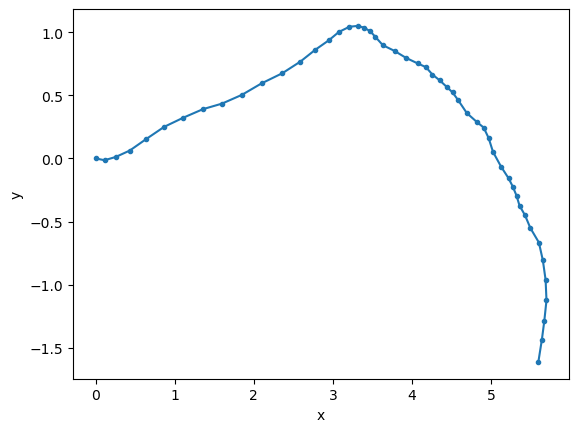

In [6]:
plt.plot(state[:, 0], state[:, 1], '.-')
plt.xlabel('x')
_ = plt.ylabel('y')

In [7]:
# Create observation model. We only observe the position.
observation_model = np.array([[1.0, 0.0, 0.0, 0.0],
                              [0.0, 1.0, 0.0, 0.0]])
observation_noise_covariance = np.array([[0.01, 0.0],
                                         [0.0, 0.01]])

In [8]:
# Create noisy observations.
observation = []
for current_state in state:
    noise_sample = adskalman.rand_mvn(np.zeros(2), observation_noise_covariance, 1).T
    current_observation = np.dot(observation_model, column(current_state)) + noise_sample
    observation.append(current_observation[:, 0])
observation = np.array(observation)

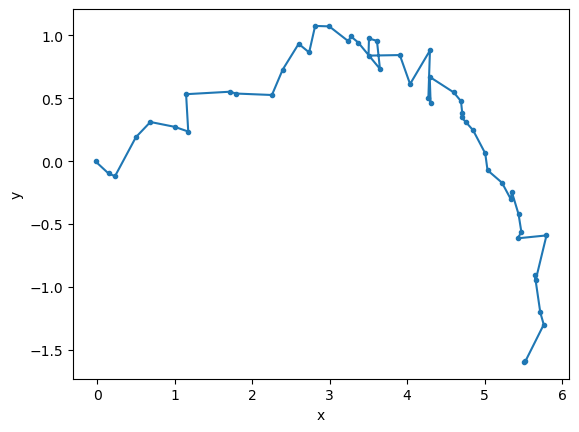

In [9]:
plt.plot(observation[:, 0], observation[:, 1], '.-')
plt.xlabel('x')
_ = plt.ylabel('y')

In [10]:
# Run kalman filter on the noisy observations.
y = observation
F = motion_model
H = observation_model
Q = motion_noise_covariance
R = observation_noise_covariance
initx = true_initial_state[:, 0]
initV = 0.1*np.eye(4)

In [11]:
kfilt = adskalman.KalmanFilter(F, H, Q, R, initx, initV)
xfilt = []
Vfilt = []
for i, y_i in enumerate(y):
    is_initial = i == 0
    xfilt_i, Vfilt_i = kfilt.step(y=y_i, isinitial=is_initial)
    xfilt.append(xfilt_i)
    Vfilt.append(Vfilt_i)
xfilt = np.array(xfilt)
Vfilt = np.array(Vfilt)

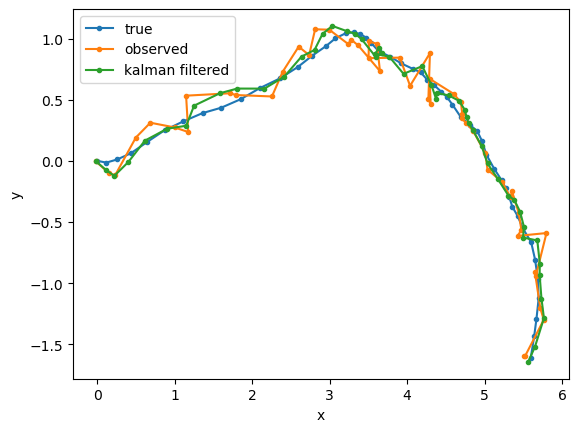

In [12]:
plt.plot(state[:, 0], state[:, 1], '.-', label='true')
plt.plot(observation[:, 0], observation[:, 1], '.-', label='observed')
plt.plot(xfilt[:, 0], xfilt[:, 1], '.-', label='kalman filtered')
plt.xlabel('x')
plt.ylabel('y')
_ = plt.legend()

In [13]:
# Now run again with missing data
y[20:30, :] = np.nan
kfilt = adskalman.KalmanFilter(F, H, Q, R, initx, initV)
xfilt = []
Vfilt = []
for i, y_i in enumerate(y):
    is_initial = i == 0
    xfilt_i, Vfilt_i = kfilt.step(y=y_i, isinitial=is_initial)
    xfilt.append(xfilt_i)
    Vfilt.append(Vfilt_i)
xfilt = np.array(xfilt)
Vfilt = np.array(Vfilt)

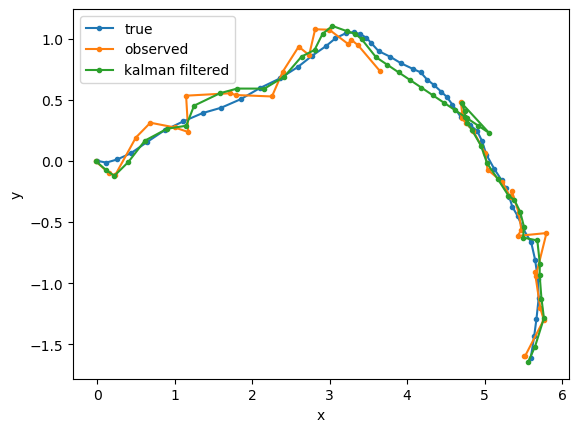

In [14]:
plt.plot(state[:, 0], state[:, 1], '.-', label='true')
plt.plot(observation[:, 0], observation[:, 1], '.-', label='observed')
plt.plot(xfilt[:, 0], xfilt[:, 1], '.-', label='kalman filtered')
plt.xlabel('x')
plt.ylabel('y')
_ = plt.legend()